# Regression Project
-------------------------------------
The goal of this project is to predict the sale price of a particular piece of heavy equipment at auction based on it's usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')

# Exploratory Data Analysis

In [3]:
df = pd.read_csv('data/Train.csv')
display(df.info())
display(df.head())

/home/benedict/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

None

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like many columns are missing values, and some columns have mixed types. Recall that we aim to predict the sale price of a particular piece of heavy equipment based on its usage, equipment type, and configuration, so we first look at what features would be unknown prior to the auction and beyond the scope of this analysis.

Prior to the auction we would not have `SalesID`, `SalePrice` (our target variable, duh), or `saledate`. Although saledate would not be known prior to the auction, we would be able to know the age of the machine by comparing `saledate`c and `YearMade`, so we should consider engineering that feature before dropping `saledate`.

Since we want to predict specifically based on usage, equipment type, and configuration, we can drop variables `datasource` and `auctioneerID`. 

The above features will be dropped prior to training the model.

### Missing Data
#### Mixed Data Types

In [4]:
df.iloc[:,[13,39,40,41]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 4 columns):
fiModelSeries      56908 non-null object
Coupler_System     43458 non-null object
Grouser_Tracks     43362 non-null object
Hydraulics_Flow    43362 non-null object
dtypes: object(4)
memory usage: 12.2+ MB


In [5]:
display(df['fiModelSeries'].unique())
# display(df.groupby('fiModelSeries')['fiModelSeries'].count())

array([nan, 'II', '-6E', 'LC', '-5', 'III', '-1', '5', '-2', '1',
       '#NAME?', '-3L', '-20', '3', '15', '-12', '6', '-6', 'V', '-3',
       '-3PT', '-21', '-7', '7', '-3MC', 'IV', '-21A', '-3LC', '-5L',
       '5N', '-5H', '-1L', '-8', '4', '2', '-18', '-15', '2T', '18', 'E',
       '-3C', '-6B', '7.00E+00', 'A', '-3LK', 'ZTS', '-2N', '12', 'V-2',
       'XT', '-7E', '-2C', '-8E', '-6LC', '-3H', '16', 'IV-2', '-6K',
       '6F', '22', '3A', 'VHP', 'LGP', 'LT', '14FT', 'EX', '-6C', '3C',
       '-7K', '17', '1970', '-2LC', 'M', 'D', 'ZX', 'LV', '-5LC', '-5E',
       '6.00E+00', '-17', '-16', '-4', '8', '-7B', '-1C', '-11', 'L',
       '-6A', 'LL', -5.0, -2.0, -8.0, -3.0, -7.0, 2.0, 'G', 'WX', '-2A',
       '-5F', '-3M', 'D7', '7A', ' III', 'AWS', '2B', '20', '-5A', '-6LK',
       '-2E', 'VI', 'H', '-1B', '-3EO', 'TC', 'Elite', 'WT', 'XLT',
       'SeriesII', '-1.50E+01', 'GALEO', '6L', '6LE', '6LK',
       '21KomStatII', '21KomStat', '7L', 'Q', 'ZHS', 'FASTRRACK'],
      dtype=objec

For some reason this model information is not available for many data points. Further inspection of the rest of the columns that are descriptive of the model may help inform how to handle this column.

In [6]:
display(df['Coupler_System'].unique())
display(df.groupby('Coupler_System')['Coupler_System'].count())

array([nan, 'None or Unspecified', 'Yes'], dtype=object)

Coupler_System
None or Unspecified    40430
Yes                     3028
Name: Coupler_System, dtype: int64

In [7]:
display(df['Grouser_Tracks'].unique())
display(df.groupby('Grouser_Tracks')['Grouser_Tracks'].count())

array([nan, 'None or Unspecified', 'Yes'], dtype=object)

Grouser_Tracks
None or Unspecified    40515
Yes                     2847
Name: Grouser_Tracks, dtype: int64

In [8]:
display(df['Hydraulics_Flow'].unique())
display(df.groupby('Hydraulics_Flow')['Hydraulics_Flow'].count())

array([nan, 'Standard', 'High Flow', 'None or Unspecified'], dtype=object)

Hydraulics_Flow
High Flow                553
None or Unspecified       25
Standard               42784
Name: Hydraulics_Flow, dtype: int64

It seems that for the last three columns it would be appropriate to fill in the NaN's with 'None or Unspecified'.

#### `auctioneerID`

We already decided that `auctioneerID` was going to be dropped, so we ignore that for now.

#### `MachineHoursCurrentMeter`

In [9]:
print('Missing Values:', df['MachineHoursCurrentMeter'].isna().sum(),
      '\n\nUnique Values:', df['MachineHoursCurrentMeter'].unique())
display(df.groupby('MachineHoursCurrentMeter')['MachineHoursCurrentMeter'].count())

Missing Values: 258360 

Unique Values: [   68.  4640.  2838. ...  8298. 35740. 12201.]


MachineHoursCurrentMeter
0.0          73126
2.0             18
3.0             21
4.0             35
5.0             44
6.0             20
7.0             12
8.0             18
9.0             13
10.0            33
11.0            12
12.0            12
13.0            20
14.0             9
15.0            17
16.0             8
17.0             7
18.0             8
19.0             6
20.0            10
21.0             5
22.0             7
23.0            10
24.0            41
25.0             9
26.0             8
27.0             9
28.0             8
29.0             7
30.0             8
             ...  
861300.0         1
886200.0         1
892700.0         1
906100.0         1
922100.0         1
932000.0         1
934400.0         1
945300.0         1
968400.0         1
974400.0         1
991000.0         1
1064900.0        1
1098000.0        1
1112100.0        1
1148500.0        1
1189500.0        1
1194900.0        1
1203000.0        1
1209500.0        1
1228200.0        1
128270

In [10]:
missing_machine_df = df[df['MachineHoursCurrentMeter'].isna()]
has_machine_df = df[df['MachineHoursCurrentMeter'].isna()==False]

In [11]:
has_machine_df['MachineHoursCurrentMeter'].describe()

count    1.427650e+05
mean     3.457955e+03
std      2.759026e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.025000e+03
max      2.483300e+06
Name: MachineHoursCurrentMeter, dtype: float64

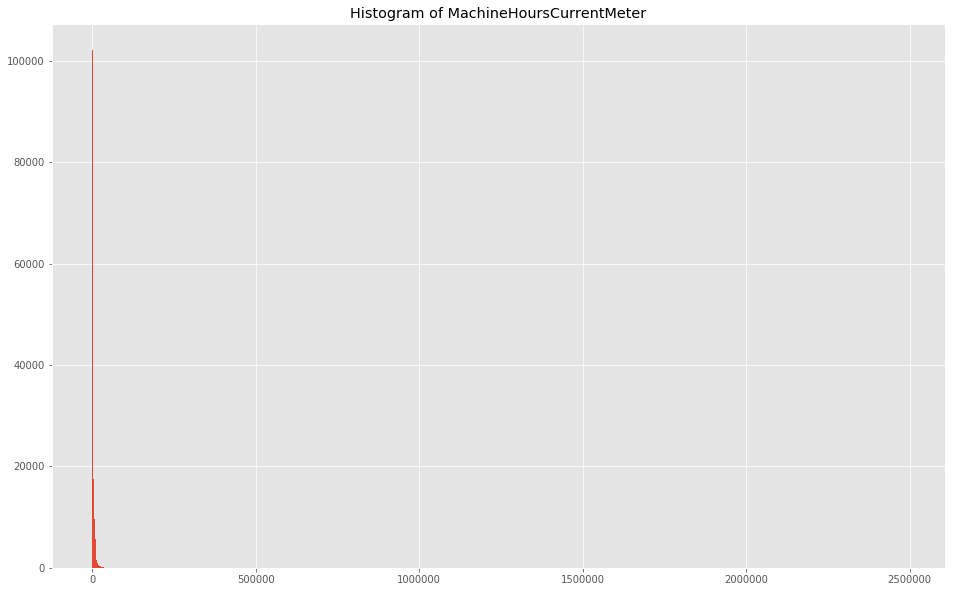

In [12]:
plt.figure(figsize=(16,10))
plt.hist(has_machine_df['MachineHoursCurrentMeter'],bins=1000);
plt.title('Histogram of MachineHoursCurrentMeter');

`MachineHoursCurrentMeter` is missing quite a few values, and the mode of the data appears to be 0. Intuitively, I would like to fill these missing values with 0, but I want to inspect this feature further in order to figure out how to handle it.

In [13]:
models = df['ModelID'].unique()
model_count = len(models)
missing_count = missing_machine_df.groupby('ModelID')['ModelID'].count()
has_count = has_machine_df.groupby('ModelID')['ModelID'].count()

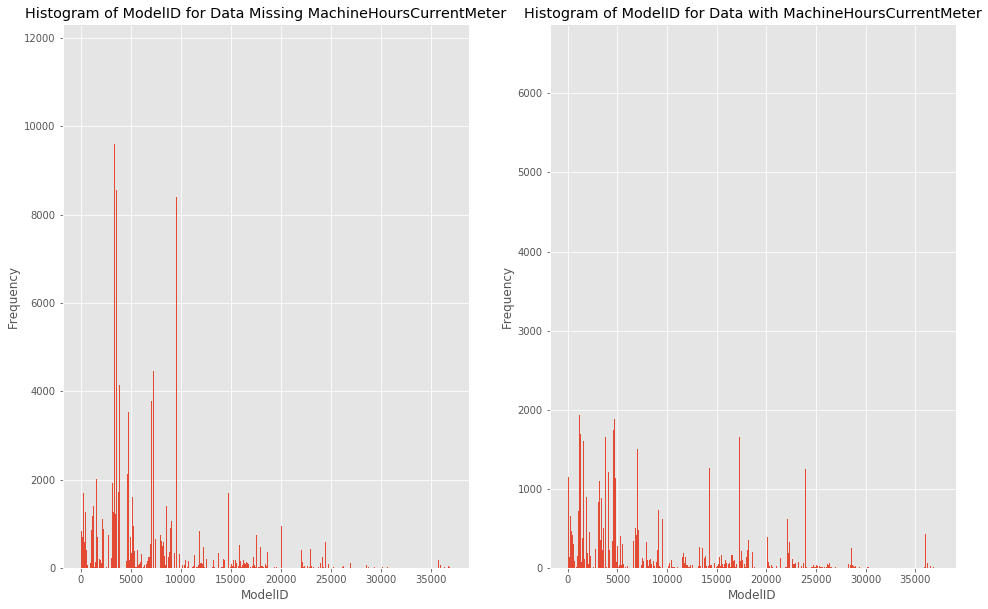

In [14]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(121)
ax.set_xlabel('ModelID')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of ModelID for Data Missing MachineHoursCurrentMeter')
ax.hist(missing_machine_df['ModelID'], bins=1000);
ax = fig.add_subplot(122)
ax.hist(has_machine_df['ModelID'], bins=1000);
ax.set_xlabel('ModelID')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of ModelID for Data with MachineHoursCurrentMeter');

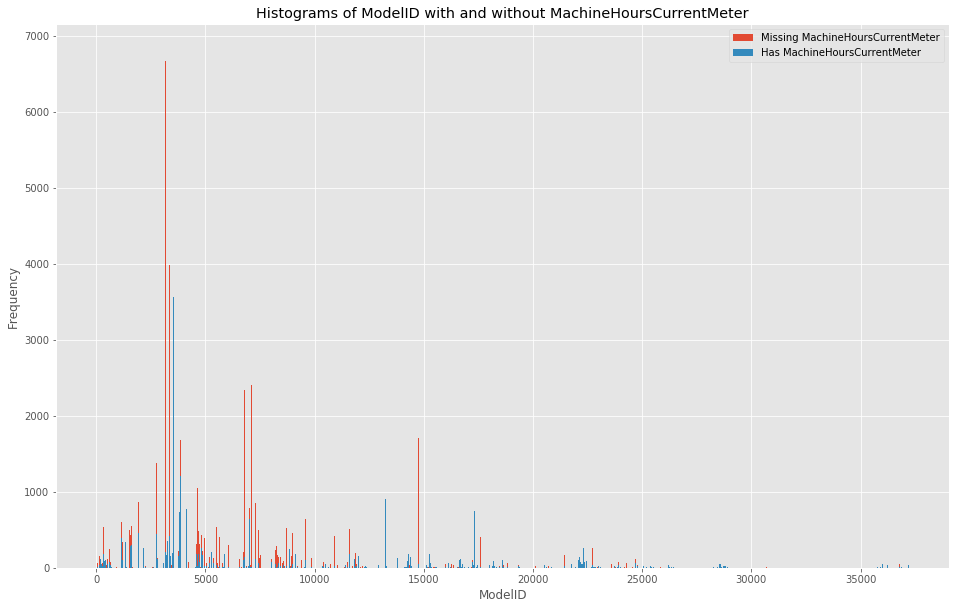

In [15]:
plt.figure(figsize=(16,10))
plt.xlabel('ModelID')
plt.ylabel('Frequency')
plt.title('Histograms of ModelID with and without MachineHoursCurrentMeter')
plt.hist(missing_machine_df['ModelID'], bins=model_count, label='Missing MachineHoursCurrentMeter');
plt.hist(has_machine_df['ModelID'], bins=model_count, label = 'Has MachineHoursCurrentMeter');
plt.legend();

It appears that `MachineHoursCurrentMeter` is missing values for certain models more than others, but for simplicity's sake I will proceed with just filling in with the mode and adding a boolean variable to indicate that it was missing.

#### `UsageBand`

In [16]:
print('Missing Values:', df['UsageBand'].isna().sum(),
      '\n\nUnique Values:', df['UsageBand'].unique())
display(df.groupby('UsageBand')['UsageBand'].count())

Missing Values: 331486 

Unique Values: ['Low' 'High' 'Medium' nan]


UsageBand
High      12034
Low       23620
Medium    33985
Name: UsageBand, dtype: int64

Intuition and a little bit of research indicates that this feature has to do with what radio frequency band the equipment operates on. I believe it is suitable to fill the NaN's with 'None or Unspecified' in this case.

#### `fiSecondaryDesc`

In [17]:
print('Missing Values:', df['fiSecondaryDesc'].isna().sum(),
      '\n\nUnique Values:', df['fiSecondaryDesc'].unique())
display(df.groupby('fiSecondaryDesc')['fiSecondaryDesc'].count())

Missing Values: 137191 

Unique Values: ['D' 'F' nan 'G' 'E' 'HAG' 'B' 'NX' 'SUPER K' 'STD' 'BL' 'Z' 'C' 'XT' 'A'
 'H' 'MR' 'PT' 'L' 'M' 'J' 'SE' 'SXT' 'HD' 'LC' 'SUPER M' 'LX' 'SUPER L'
 'LE' 'K' 'S' 'R' 'P' 'SG' 'US' 'UU' 'WX' 'PX' 'N' 'ZTM' 'SUPER E' 'XL'
 'MXT' 'EX' '-2' 'LCM' 'GT' 'TM' 'HZ' 'AX' 'DXT' '3' 'SR' '7' 'ZTS'
 'B     ' 'T' 'UR' '-3' 'V' 'ZT' '1' 'SUPER M PLUS' 'BZD' 'DZ' 'WD' 'LGP'
 'SRLC' 'CH' 'CS' 'M      ' 'ZHS G' 'Q' 'MRX' 'FR' 'UNA' 'R-2' 'PS' 'AG'
 'URG' 'NE' 'U' '2' 'SB' 'TX' 'TTL' 'JX' 'LT' 'MSR SPIN ACE' 'HF' 'HDSL'
 'LCD' 'X' 'LS' 'EST' 'LR' 'TC' 'BLGP' 'USR' 'RC' 'SJ' 'ZF' 'SUPER LE'
 'MT' 'SUPER R' 'C      ' 'BEC' 'DC' 'CE' 'AB' 'MU' 'USRK' 'W' '-7' 'SL'
 'SU' '0.7' 'THF' 'ZX' 'NL' 'CX' 'SRDZ' 'H90' 'AW' 'SP' 'EL' 'PL' '#NAME?'
 'ESS' 'CM' 'CL' 'EW' 'ZHS' 'CR' 'CKB' 'CK' 'DX' 'SX' 'HL' 'HDS' 'DT'
 'LCH' '5' 'H      ' 'SUPER' 'IV' 'XP' 'LD' 'LC7A' 'SF' 'PG' 'SPIN ACE'
 'HX' 'EG' 'HLGP' 'WT' 'XLT' 'MSR' 'BLGPPS' 'AA' 'BZ' 'TP' 'CLR' 'MC'
 'HLS' 'DL' 'USBL' 'LC

fiSecondaryDesc
 MSR SPIN ACE        1
#NAME?              10
-2                  21
-3                   5
-5                   7
-5L                  7
-6                   1
-7                   2
0.7                  8
1                    7
2                    3
3                  125
5                    1
7                  112
A                 5504
AA                   6
AB                   4
AG                  26
AW                   7
AX                  94
B                39203
B                   48
BEC                  7
BL                 562
BLGP                 4
BLGPPS               1
BZ                   6
BZD                 16
C                43235
C                   10
                 ...  
TP                   4
TTL                  1
TX                  27
U                  168
UNA                  3
UR                 820
URG                456
US                 838
USBL                 1
USR                 69
USRK                 3
UU                

#### `fiModelDescriptor`

In [18]:
print('Missing Values:', df['fiModelDescriptor'].isna().sum(),
      '\n\nUnique Values:', df['fiModelDescriptor'].unique())
display(df.groupby('fiModelDescriptor')['fiModelDescriptor'].count())

Missing Values: 329206 

Unique Values: [nan 'LC' '6' 'L' 'LT' 'CR' 'SB' 'XL' 'LGP' 'VHP' '7' 'Z' '2.00E+00' 'MC'
 'H' 'E' '3' 'LK' '5' 'K' '8' 'HT' 'LX' 'XLT' 'XW' 'HSD' '2' 'XR' 'TC'
 'LCR' 'TLB' 'WT' 'TURBO' 'U' '4WD' 'XT' 'LRC' 'ZTS' 'RTS' 'TP' 'LE' 'LRR'
 'SA' '3C' 'SR' 'XP' '1' 'BE' '3NO' 'CRSB' 'N' 'SSR' 'DHP' 'LM' ' SUPER'
 'KA' 'H5' 'II' 'MH' 'P' 'LU' 'DT' 'XTV' 'LR' 'ZX' 'LL' 'V' 'DELUXE'
 'USLC' 'SU' 'SRDZ' 'C' 'PRO' 'PLUS' 'SITEMASTER' 'DINGO' '3.00E+00'
 ' XLT' 'LN' 'AE0' 'SERIES3' '7.00E+00' 'ESL' 'A' 'G' 'B' 'DLL' 'CK'
 'NSUC' 'LS' 'SLGP' 'RR' 'WLT' 'LCRTS' 'X' 'LCH' 'T' 'NLC' 'SM' 'SE' 'TM'
 'SRLC' 'CUSTOM' 'HD' 'DW' 'LC8' ' LGP' 'TK' 'HF' 'SUPER K' 'IV' ' XT'
 'IT' 'XLVP' 'LGPVP' 'K5' '3L' '7A' 'XD' 'DA' 'Y' 'S' 'M' '6K' 'LITRONIC'
 'KBNA' ' 14FT' '2N' 'III' 'ME' 'High Lift' 'HighLift' 'VHP/AWD' 'K3'
 '4x4x4' ' ZX' '(BLADE RUNNER)' 'AVANCE' 'GALEO' 'LongReach']


fiModelDescriptor
 14FT                5
 LGP                 8
 SUPER               7
 XLT                 3
 XT                  2
 ZX                  2
(BLADE RUNNER)       4
1                   59
2                  528
2.00E+00            38
2N                   4
3                 1887
3.00E+00            32
3C                  49
3L                   1
3NO                 42
4WD                 87
4x4x4                1
5                 2246
6                 2885
6K                   2
7                  918
7.00E+00             6
7A                   4
8                  280
A                  300
AE0                  1
AVANCE              11
B                    3
BE                  11
                  ... 
SU                  34
SUPER K              2
T                    1
TC                 186
TK                   1
TLB                 47
TM                  10
TP                  16
TURBO                2
U                  275
USLC                 1
V               

The `fiModel` features appear to collectively describe the model of the equipment. I believe it would be best to simply combine these features into one long string.

In [19]:
df['fiModel'] = df['fiModelDesc'] + '-' +\
                df['fiBaseModel'] + '-' + \
                df['fiSecondaryDesc'].fillna('_') + '-' + \
                df['fiModelSeries'].fillna('').astype(str) + '-' + \
                df['fiModelDescriptor'].fillna('')

In [20]:
df['fiModel'].size

401125

Now there are 5018 unique model types.

#### `ProductSize`

In [21]:
print('Missing Values:', df['ProductSize'].isna().sum(),
      '\n\nUnique Values:', df['ProductSize'].unique())
display(df.groupby('ProductSize')['ProductSize'].count())

Missing Values: 210775 

Unique Values: [nan 'Medium' 'Small' 'Large / Medium' 'Mini' 'Large' 'Compact']


ProductSize
Compact            6089
Large             20975
Large / Medium    49678
Medium            62274
Mini              24840
Small             26494
Name: ProductSize, dtype: int64

In [22]:
(df['fiModel']+df['ProductSize'].fillna('-')).unique().size

5102

Some of the models we have match to multiple `ProductSize` values. So, we can use our engineered `fiModel` feature to see if any of these missing values can be filled.

In [23]:
grouped = df.fillna('-').groupby('fiModel')
grouped['ProductSize'].unique()[(grouped['ProductSize'].nunique() != 1).values].head()

fiModel
120-120-_--      [Small, -, Large / Medium]
125-125-_--     [Large / Medium, Medium, -]
125B-125-B--       [Medium, Large / Medium]
125C-125-C--       [Medium, Large / Medium]
160-160-_--         [Large / Medium, Small]
Name: ProductSize, dtype: object

Using our engineered `fiModel` may be unreliable, so we try the same with `ModelID`.

In [24]:
grouped = df.fillna('-').groupby('ModelID')
grouped['ProductSize'].unique()[(grouped['ProductSize'].nunique() != 1).values].head()

Series([], Name: ProductSize, dtype: object)

There appears to be a discrepancy between `ModelID` and our engineered `fiModel` feature.

In [25]:
grouped = df.fillna('-').groupby('fiModel')
grouped['YearMade'].unique()[(grouped['YearMade'].nunique() != 1).values].head()

fiModel
100C-100-C--      [1973, 1974, 1975, 1977, 1978, 1979, 1000]
1066-1066-_--     [1973, 1975, 1970, 1971, 1000, 1972, 1977]
1080-1080-_--     [1984, 1983, 1985, 1986, 1000, 1987, 1988]
1080B-1080-B--                [1988, 1986, 1985, 1987, 1000]
1088-1088-_--           [1989, 1990, 1000, 1991, 1992, 1988]
Name: YearMade, dtype: object

So now we see that some `YearMade` values are 1000, which is problematic, but I want to see if how `ModelID` and `YearMade` line up.

In [26]:
grouped = df.fillna('-').groupby('ModelID')
year_ = grouped['YearMade'].unique()[(grouped['YearMade'].nunique() != 1).values]

I believe the best course of action is to use the mode by `ModelID` to fill the missing gaps in the above columns and `YearMade`.

#### `YearMade`

In [27]:
year_1000_df = df[df['YearMade'] != 1000]
grouped = year_1000_df.groupby('ModelID')
year_grouped = grouped['YearMade'].value_counts()
year_dict = {}

for model in year_grouped.index.levels[0]:
    if year_grouped[model].idxmax() != 1000:
        year_dict[model] = year_grouped[model].idxmax()

In [28]:
outFile = open('year_dict.py', 'w')
outFile.write('year_dict = '+str(year_dict))
outFile.close()

In [29]:
len(year_dict.keys())

4774

In [30]:
for model in year_dict.keys():
    df.loc[(df.loc[:,'ModelID']==model) & (df.loc[:,'YearMade'] == 1000), 'YearMade'] = 1000

In [31]:
df['ModelID'][df['YearMade'] == 1000].unique().size

3379

#### `Drive_System`

#### `Enclosure`

#### `Forks`

#### `Pad_Type`

#### `Ride_Control`

#### `Stick`

#### `Transmission`

#### `Turbocharged`

#### `Blade_Extension`

#### `Blade_Width`

#### `Enclosure_Type`

#### `Engine_Horsepower`

#### `Hydraulics`

#### `Pushblock`

#### `Ripper`

#### `Scarifier`

#### `Tip_Control`

#### `Tire_Size`

#### `Coupler`

#### `Track_Type`

#### `Undercarriage_Pad_Width`

#### `Stick_Length`

#### `Thumb`

#### `Pattern_Changer`

#### `Grouser_Type`

#### `Backhoe_Mounting`

#### `Blade_Type`

#### `Travel_Controls`

#### `Differential_Type`

#### `Steering_Controls`